# LSTM-VAE Forecasting and Evaluation

## Load libraries

In [15]:

import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd


In [16]:
class LSTMVAE(nn.Module):
    def __init__(self, num_input, num_hidden, num_layers, dropout, output_window, output_dim):
        super(LSTMVAE, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = num_hidden
        self.output_window = output_window
        self.output_dim = output_dim

        # Encoder
        self.encoder = nn.LSTM(num_input, num_hidden, num_layers, batch_first=True, dropout=dropout)

        # Latent space
        self.scale = nn.Sequential(nn.Linear(num_hidden, num_hidden), nn.Tanh())
        self.mu = nn.Linear(num_hidden, num_hidden)
        self.log_var = nn.Linear(num_hidden, num_hidden)

        # Decoder: Linear layer maps from latent to full output window of target variable
        self.decoder = nn.Linear(num_hidden, output_window)

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        _, (h_n, _) = self.encoder(x)  # shape: (num_layers, batch, hidden_size)
        return self.scale(h_n[-1])     # shape: (batch, hidden_size)

    def decode(self, encoded, z):
        out = encoded * (1 + z)  # shape: (batch, hidden_size)
        # out = encoded #* (1 + z)  # shape: (batch, hidden_size)
        decoded = self.decoder(out)  # shape: (batch, output_window * output_dim)
        return decoded.view(-1, self.output_window)#, self.output_dim)  # reshape to (batch, 100, 1)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        z = self.reparametrize(mu, log_var)
        decoded = self.decode(encoded, z)
        return decoded, mu, log_var

    def sample(self, x, num_samples):
        encoded = self.encode(x).unsqueeze(1).repeat(1, num_samples, 1)
        z = torch.randn((x.size(0), num_samples, self.hidden_size)).to(x.device)
        decoded = self.decoder(encoded * (1 + z))
        return decoded.view(x.size(0), num_samples, self.output_window, self.output_dim)


In [17]:
def create_sequences(dataframe, input_window=500, output_window=1, step=24, offset=100):
    appliances_idx = dataframe.columns.get_loc("Appliances")

    X_data = dataframe.values  # full multivariate data
    y_data = dataframe["Appliances"].values  # target column

    X, y = [], []
    for i in range(0, len(dataframe) - input_window - offset - output_window + 1, step):
        X.append(X_data[i : i + input_window])
        y.append(y_data[i + input_window + offset : i + input_window + offset + output_window])

    X = np.array(X)
    y = np.array(y)

    print(f"✅ X shape: {X.shape} (samples, input_window, input_features)")
    print(f"✅ y shape: {y.shape} (samples, output_window)")

    return X, y


def safe_rolling_sum(df, column="Appliances", window=7*24*6):  # 1008
    values = df[column].values.astype(np.float64)
    cum = np.cumsum(np.insert(values, 0, 0))  # Pad with zero for correct diff
    result = cum[window:] - cum[:-window]
    padded_result = np.concatenate([np.full(window-1, result[0]), result])
    df['Appliances_cumulative'] = padded_result
    return df


def get_dataloaders(csv_path, input_window=500, output_window=100, offset=100):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    # OPTIONAL: You can print this to confirm column names
    # print(df.columns)
    batch_size = 32
    # Ensure all values are float32 except the index
    df = df.astype(np.float32)

    df['Appliances'] = df['Appliances'].rolling(6*6, min_periods=1).mean()
    # df['Appliances'] = np.log1p(df['Appliances'])

    # Create sequences using the DataFrame (so we can access column names)
    X, y = create_sequences(df, input_window=input_window, output_window=output_window, offset=offset)

    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Split (e.g., 70% train, 15% val, 15% test)
    total_samples = len(X)
    train_end = int(0.7 * total_samples)
    val_end = int(0.85 * total_samples)

    train_dataset = torch.utils.data.TensorDataset(X[:train_end], y[:train_end])
    val_dataset = torch.utils.data.TensorDataset(X[train_end:val_end], y[train_end:val_end])
    test_dataset = torch.utils.data.TensorDataset(X[val_end:], y[val_end:])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Load model and data

In [19]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMVAE(num_input=26, num_hidden=128, num_layers=2, dropout=0.3, output_window=1, output_dim=1)
model_path = os.path.join("lstmvae_1step.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

_, _, test_loader = get_dataloaders(
    csv_path=os.path.join('processed_energy.csv'),
    input_window=100,
    output_window=1)


✅ X shape: (814, 100, 26) (samples, input_window, input_features)
✅ y shape: (814, 1) (samples, output_window)


## Forecast with uncertainty (first 100 points)

In [20]:

# [Paste the complete logic of forecast_with_uncertainty, inverse_transform_column, plotting, etc. here]
def inverse_transform_column(scaler, data, target_index):
    dummy = np.zeros((len(data), scaler.data_min_.shape[0]))
    dummy[:, target_index] = data[:, 0]
    return scaler.inverse_transform(dummy)[:, target_index]


def forecast_with_uncertainty(model, test_loader, device, forecast_steps, num_samples=100):
    model.eval()
    predictions, lower_bounds, upper_bounds, y_true = [], [], [], []

    X_test_windows = []
    for X_batch, y_batch in test_loader:
        for x, y in zip(X_batch, y_batch):
            X_test_windows.append(x)
            y_true.append(y[0].item())
            if len(X_test_windows) >= forecast_steps:
                break
        if len(X_test_windows) >= forecast_steps:
            break

    with torch.no_grad():
        for X_input in X_test_windows:
            X_tensor = X_input.unsqueeze(0).to(device)
            samples = model.sample(X_tensor, num_samples=num_samples).squeeze(-1).squeeze(0)

            predictions.append(samples.mean(dim=0).cpu().numpy()[0])
            lower_bounds.append(torch.quantile(samples, 0.05, dim=0).cpu().numpy()[0])
            upper_bounds.append(torch.quantile(samples, 0.95, dim=0).cpu().numpy()[0])

    return (
        np.array(predictions).reshape(-1, 1),
        np.array(lower_bounds).reshape(-1, 1),
        np.array(upper_bounds).reshape(-1, 1),
        np.array(y_true).reshape(-1, 1)
    )


def plot_forecast(y_true_inv, y_pred_inv, y_lower_inv, y_upper_inv, target_column, output_path):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_inv, label="True (Test)", linewidth=2, color='blue')
    plt.plot(y_pred_inv, label="Forecast (LSTM-VAE)", linestyle='--', color='orange')
    plt.fill_between(np.arange(len(y_true_inv)), y_lower_inv, y_upper_inv,
                     alpha=0.3, label="90% Confidence Interval", color='orange')

    plt.title("LSTM-VAE Forecast with Uncertainty (First 100 Test Points)")
    plt.xlabel("Time step")
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.show()


def test_lstm_vae_forecast(model, test_loader, device, scaler, forecast_steps=100, target_column="Appliances"):
    target_index = list(scaler.feature_names_in_).index(target_column)

    y_pred, y_lower, y_upper, y_true = forecast_with_uncertainty(
        model, test_loader, device, forecast_steps
    )

    y_true_inv = inverse_transform_column(scaler, y_true, target_index)
    y_pred_inv = inverse_transform_column(scaler, y_pred, target_index)
    y_lower_inv = inverse_transform_column(scaler, y_lower, target_index)
    y_upper_inv = inverse_transform_column(scaler, y_upper, target_index)

    plot_path = os.path.join("src", "adc_testdatascience_2", "scripts", "plots", "lstmvae_direct_forecast_uncertainty.png")
    plot_forecast(y_true_inv, y_pred_inv, y_lower_inv, y_upper_inv, target_column, plot_path)

    print("✅ LSTM-VAE forecast with uncertainty complete and plot saved.")





✅ X shape: (814, 100, 26) (samples, input_window, input_features)
✅ y shape: (814, 1) (samples, output_window)


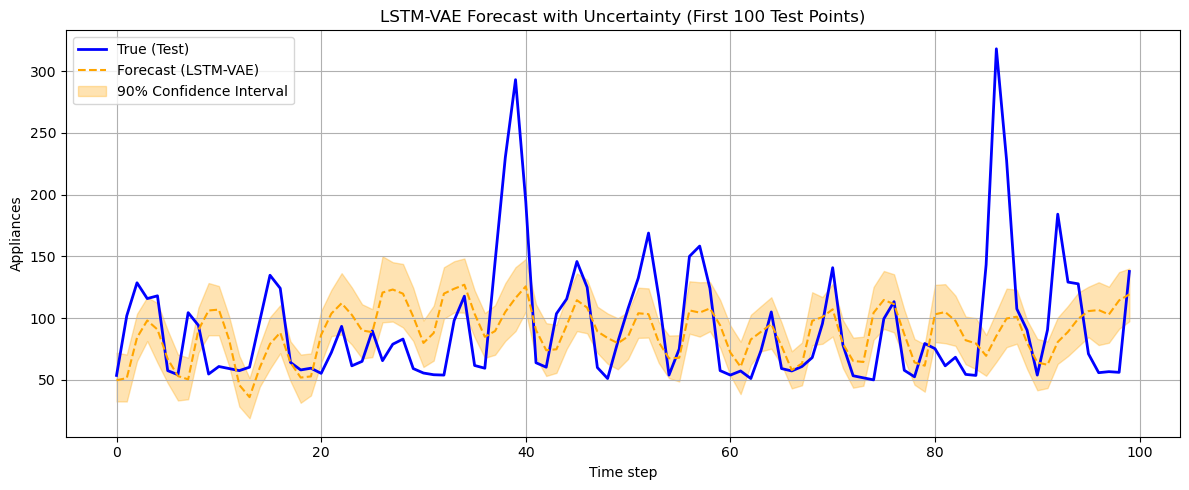

✅ LSTM-VAE forecast with uncertainty complete and plot saved.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMVAE(
    num_input=26, num_hidden=128, num_layers=2,
    dropout=0.3, output_window=1, output_dim=1
)
model_path = os.path.join("lstmvae_1step.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

data_path = os.path.join("processed_energy.csv")
_, _, test_loader = get_dataloaders(
    csv_path=data_path,
    input_window=100,
    output_window=1
)

scaler_path = os.path.join("processed_energy_scaler.pkl")
scaler = joblib.load(scaler_path)

test_lstm_vae_forecast(
    model=model,
    test_loader=test_loader,
    device=device,
    scaler=scaler,
    forecast_steps=100,
    target_column="Appliances"
)
